In [1]:
%matplotlib inline 
import variable_simulations as vs
import dataset_specific_functions as dsf 
import numpy as np 

%load_ext autoreload
%autoreload 2

In [42]:
ogle4_dir = '/Users/jill/Research/Surveys/OGLE/OGLEIV/LMC/'

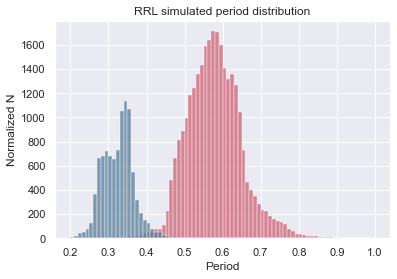

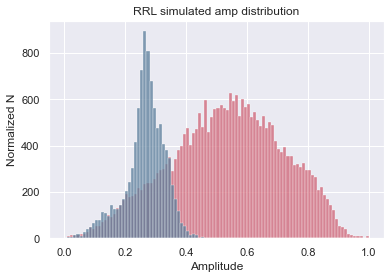

In [3]:
# LMC distribution of RR Lyrae stars
period_bins_c, fo_period_prob, fu_period_prob = vs.get_period_distribution('RRL', ogle4_dir)
amp_bins_c, fo_amp_prob, fu_amp_prob = vs.get_amp_distribution('RRL', ogle4_dir)

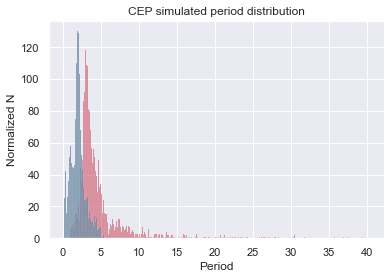

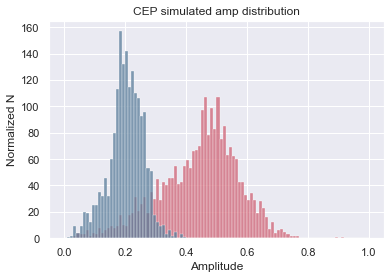

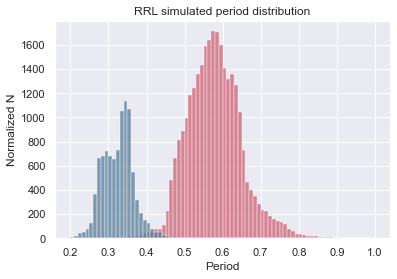

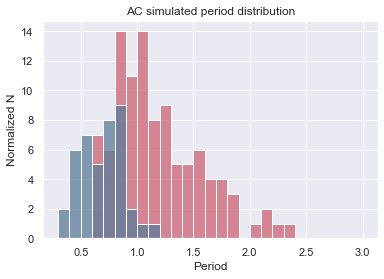

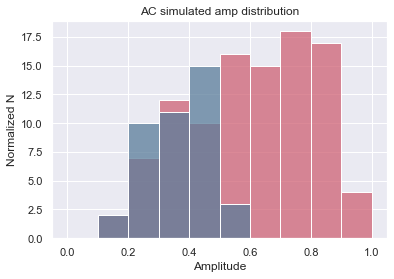

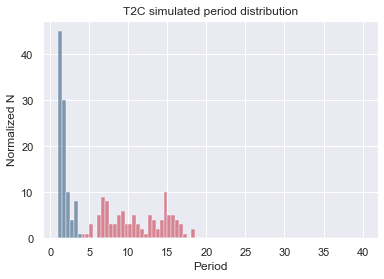

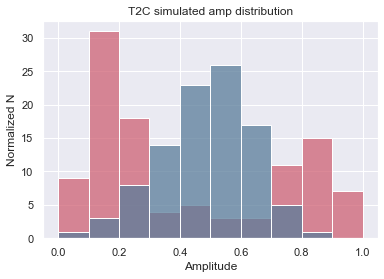

[(  1, 'CEP', 'FO', 1.20241664, 15.93758829, 0.15332947)
 ( 51, 'CEP', 'FU', 3.18981605, 14.98281021, 0.36582543)
 (101, 'RRL', 'FO', 0.30404947, 18.93946281, 0.30363907)
 (151, 'RRL', 'FU', 0.6577551 , 18.52806087, 0.08157591)
 (201, 'AC', 'FO', 0.55412235, 17.67833372, 0.43757544)
 (251, 'AC', 'FU', 1.95124688, 16.88653209, 0.24646642)
 (301, 'T2C', 'FO', 1.10338133, 17.22788128, 0.6589666 )
 (351, 'T2C', 'FU', 8.57941746, 15.45686091, 0.19391373)]


In [96]:
# Generate simulated data for 100 Cepheids and RR Lyrae stars 
sim_data = vs.simulate_params(['CEP', 'RRL', 'AC', 'T2C'], 50, ogle4_dir)
print(sim_data[0:-1:50])

In [2]:
catalog_file = 'test_data/M33-A_RRL-ACSarc_F0_epochcat_analysis.fits'
ids, chip, cat_data = dsf.read_catalog(catalog_file)


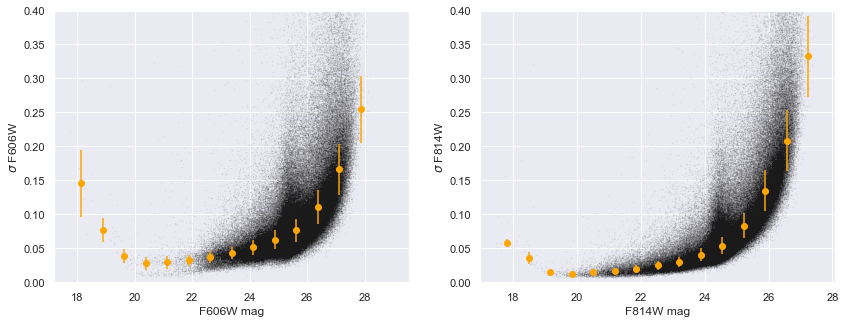

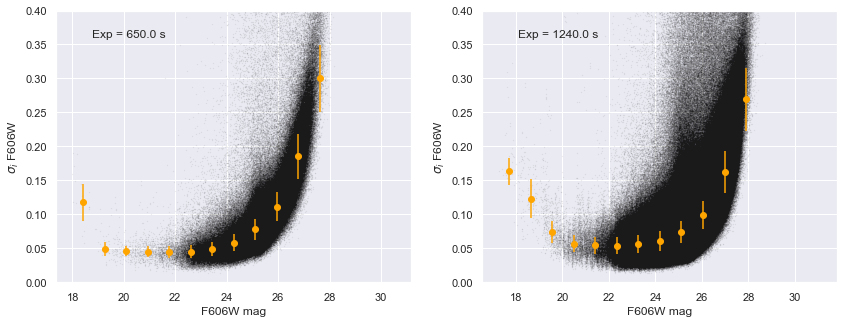

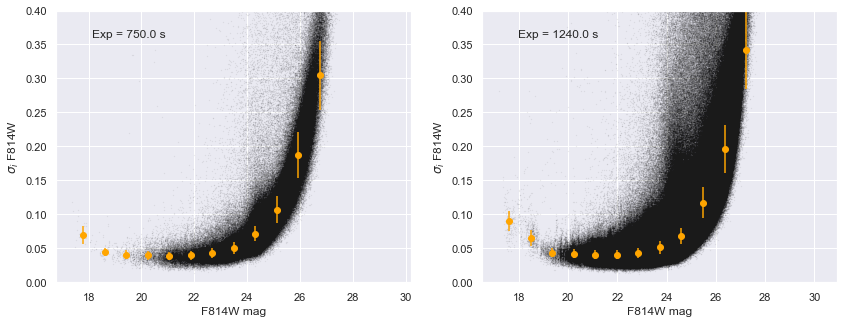

In [36]:
error_key, error_array, scatter_array = dsf.get_dataset_properties(cat_data['filters'], 
    cat_data['mag'], cat_data['emag'], cat_data['mag_sw'], cat_data['mag_stddev_sw'], 
    cat_data['sharp_sw'][:,1], cat_data['exp_times'])

In [87]:
print(error_key)
print(error_array[[3][0],:,1])

test = np.interp(20.4077, error_array[3,:,0], error_array[3,:,1])
print(test)

[('V',  650.) ('V', 1240.) ('I',  750.) ('I', 1240.)]
[0.0902     0.0649     0.0438     0.042      0.0405     0.0409
 0.0432     0.0518     0.0686     0.1174     0.1962     0.34150001
 0.9601     4.66139984 7.52645016]
0.04169093145345219


In [98]:
output_dir = 'test_data/simulated_lcvs/'
distance = 24.8

filters_new = np.copy(cat_data['filters'][0])
filters_new[filters_new == 'F606W'] = 'V'
filters_new[filters_new == 'F814W'] = 'I'
error_key['filter'][error_key['filter'] == 'F606W'] = 'V'
error_key['filter'][error_key['filter'] == 'F814W'] = 'I'

vs.make_simulated_lcv(sim_data, cat_data['mjd_obs'][0], filters_new, 
    cat_data['exp_times'][0], distance, scatter_array, error_key, error_array, 
    output_dir, append=False)

['I' 'V']
[22.26058829 23.01298104]


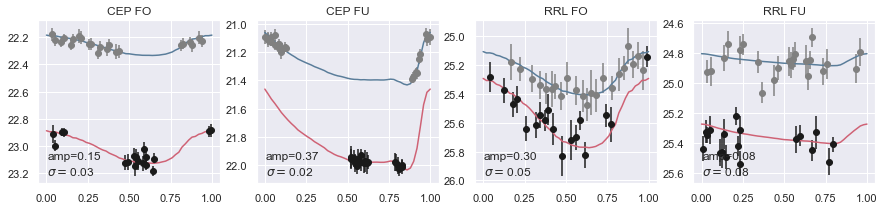

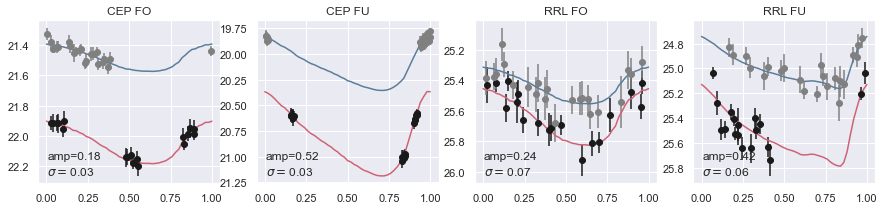

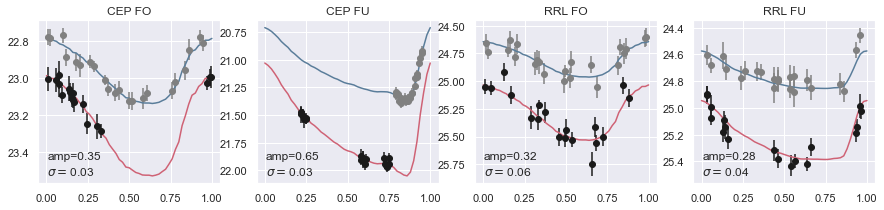

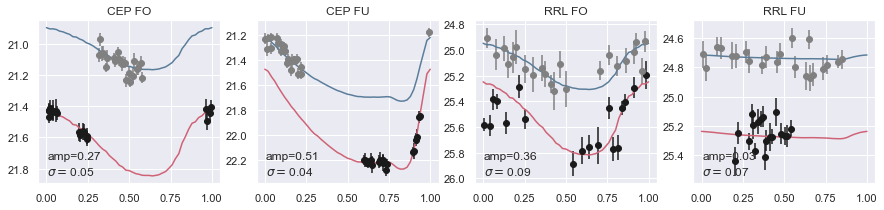

In [99]:
# Plot a few light curves 
import matplotlib.pyplot as plt 

# read parameter file 
dt = np.dtype([('id', int), ('type', 'U3'), ('mode', 'U2'), ('template', int), ('period', float), 
              ('t0', float), ('mag1', float), ('amp1', float), ('sig1', float), ('mag2', float), 
              ('amp2', float), ('sig2', float)])
data = np.loadtxt('test_data/simulated_lcvs/true_params.txt', dtype=dt)

# Get template light curves
template_file = '/Users/jill/python/fitlc/var_templates.txt'
dt = np.dtype([('phase', float), ('ab1', float), ('ab2', float),
        ('ab3', float), ('ab4', float), ('ab5', float), ('ab6', float),
        ('c', float), ('ab7', float), ('ab8', float)])
templates = np.loadtxt(template_file, dtype=dt)
templates_new = np.c_[templates['ab1'], templates['ab2'], templates['ab3'],
        templates['ab4'], templates['ab5'], templates['ab6'], templates['c'],
        templates['ab7'], templates['ab8']]
templates_mean = np.mean(templates_new, axis=0)

for i in range(4): 
    
    var_types = ['CEP FO', 'CEP FU', 'RRL FO', 'RRL FU']
    star_indices = [i, i+50, i+100, i+150]
    
    fig, ax = plt.subplots(1,4, figsize=(15,3))
    
    for j in range(len(star_indices)):
        xx = star_indices[j]
        t = data['template'][xx]
        mag_temp1 = (templates_new[:,t]-templates_mean[t])*data['amp1'][xx] + data['mag1'][xx]
        ax[j].plot(templates['phase'], mag_temp1, color='xkcd:steel blue')
        mag_temp2 = (templates_new[:,t]-templates_mean[t])*data['amp2'][xx] + data['mag2'][xx]
        ax[j].plot(templates['phase'], mag_temp2, color='xkcd:rose')
        ax[j].set_title(var_types[j])
        ax[j].invert_yaxis()
        
        # read in lcv data 
        dt = np.dtype([('filter', int), ('mjd', float), ('mag', float), ('err', float)])
        lcv = np.loadtxt('test_data/simulated_lcvs/sim_{}.fitlc'.format(xx+1), dtype=dt, skiprows=3)
        ph = np.mod((lcv['mjd']-data['t0'][xx])/data['period'][xx], 1)
        f1 = lcv['filter'] == 1
        ax[j].errorbar(ph[f1], lcv['mag'][f1], yerr=lcv['err'][f1], fmt='o', color='k')
        f2 = lcv['filter'] == 0
        ax[j].errorbar(ph[f2], lcv['mag'][f2], yerr=lcv['err'][f2], fmt='o', color='gray')
        
        ax[j].text(0.05, 0.15, 'amp={:.2f}'.format(data['amp1'][xx]), transform=ax[j].transAxes)
        ax[j].text(0.05, 0.05, '$\sigma=${:.2f}'.format(data['sig1'][xx]), transform=ax[j].transAxes)
        
    plt.show()

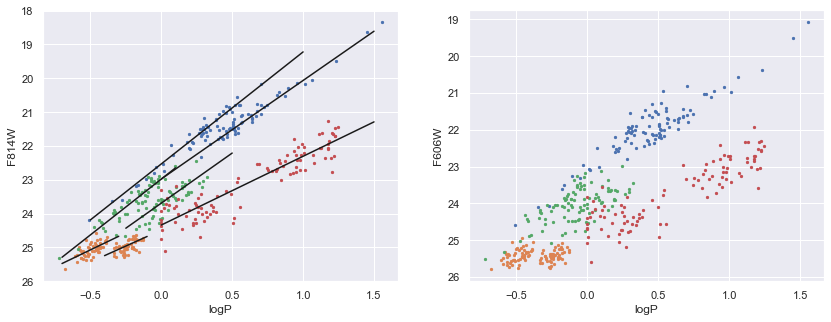

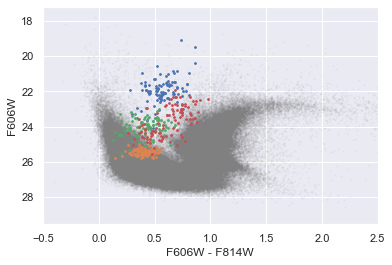

In [101]:
# Show the simulated variables

DM = 24.8
# read parameter file 
dt = np.dtype([('id', int), ('type', 'U3'), ('mode', 'U2'), ('template', int), ('period', float), 
              ('t0', float), ('Imag', float), ('Iamp', float), ('Isig', float), ('Vmag', float), 
              ('Vamp', float), ('Vsig', float)])
sim_params = np.loadtxt('test_data/simulated_lcvs/true_params.txt', dtype=dt)


cep = sim_params['type'] == 'CEP'
rrl = sim_params['type'] == 'RRL'
ac = sim_params['type'] == 'AC'
t2c = sim_params['type'] == 'T2C'

logP = np.log10(sim_params['period'])

# period luminosity 
fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].scatter(logP[cep], sim_params['Imag'][cep], s=5)
ax[0].scatter(logP[rrl], sim_params['Imag'][rrl], s=5)
ax[0].scatter(logP[ac], sim_params['Imag'][ac], s=5)
ax[0].scatter(logP[t2c], sim_params['Imag'][t2c], s=5)

fo_rrl = np.array([-0.7, -0.3])
y_rrl_fo = -2.014*fo_rrl + 17.743 - 18.477 + DM
fu_rrl = np.array([-0.4, -0.1])
y_rrl_fu = -1.889*fu_rrl + 18.164 - 18.477 + DM

fo_cep = np.array([-0.5, 1.0])
y_cep_fo = -3.311*(fo_cep-1.0) + 12.897 - 18.477 + DM
fu_cep = np.array([0.0, 1.5])
y_cep_fu = -2.912*(fu_cep-1.0) + 13.741 - 18.477 + DM
    
fo_ac = np.array([-0.7, 0.1])
y_ac_fo = -3.302*fo_ac + 16.656 - 18.477 + DM
fu_ac = np.array([-0.25, 0.5])
y_ac_fu = -2.962*fu_ac + 17.368 - 18.477 + DM

fu_t2c = np.array([0.0, 1.5])
y_t2c_fu = -2.033*fu_t2c + 18.015 - 18.477 + DM

ax[0].plot(fo_rrl, y_rrl_fo, color='k')
ax[0].plot(fu_rrl, y_rrl_fu, color='k')
ax[0].plot(fo_cep, y_cep_fo, color='k')
ax[0].plot(fu_cep, y_cep_fu, color='k')
ax[0].plot(fo_ac, y_ac_fo, color='k')
ax[0].plot(fu_ac, y_ac_fu, color='k')
ax[0].plot(fu_t2c, y_t2c_fu, color='k')

ax[0].invert_yaxis()
ax[0].set_xlabel('logP')
ax[0].set_ylabel('F814W')

ax[1].scatter(logP[cep], sim_params['Vmag'][cep], s=5)
ax[1].scatter(logP[rrl], sim_params['Vmag'][rrl], s=5)
ax[1].scatter(logP[ac], sim_params['Vmag'][ac], s=5)
ax[1].scatter(logP[t2c], sim_params['Vmag'][t2c], s=5)
ax[1].invert_yaxis()
ax[1].set_xlabel('logP')
ax[1].set_ylabel('F606W')
plt.show()


fig, ax = plt.subplots(1,1)
sel = np.abs(cat_data['sharp_sw'][:,1]) < 0.1
ax.scatter(cat_data['mag_sw'][sel,0]-cat_data['mag_sw'][sel,1], cat_data['mag_sw'][sel,0],
    s=1, alpha=0.05, color='gray')
color = sim_params['Vmag'] - sim_params['Imag']
ax.scatter(color[cep], sim_params['Vmag'][cep], s=3)
ax.scatter(color[rrl], sim_params['Vmag'][rrl], s=3)
ax.scatter(color[ac], sim_params['Vmag'][ac], s=3)
ax.scatter(color[t2c], sim_params['Vmag'][t2c], s=3)
ax.invert_yaxis()
ax.set_xlabel('F606W - F814W')
ax.set_ylabel('F606W')
ax.set_xlim(-0.5, 2.5)
plt.show()